In [125]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec 
import seaborn as sb
import numpy as np
import math

In [ ]:
import datetime
# to add the date and time into the figure title

In [7]:
path = '/Users/joeywilkes/ReservoirComputing/research_data/'
sorted(os.listdir(path))
sorted(os.listdir())

['.ipynb_checkpoints',
 'Additional Topos.ipynb',
 'JW4_barab1.ipynb',
 'Typical Analysis.ipynb',
 'Visualizing Selection of HyperParameters (jun22).ipynb',
 'jun11 analysis.ipynb',
 'june 3rd Analysis.ipynb',
 'jw5_barab2.ipynb',
 'jw7_barab1.ipynb',
 'jw8_barab1.ipynb']

In [9]:
def merge_compiled(compiled1, compiled2):
    """ Merge two compiled dictionaries """
    if isinstance(compiled1, str) and isinstance(compiled2, str):
        compiled1 = pickle.load(open(compiled1, 'rb'))
        compiled2 = pickle.load(open(compiled2, 'rb'))
    # Shift experiment number for compiled2
    total_exp = np.max(compiled1["exp_num"])
    exp_nums = np.array(compiled2["exp_num"])
    exp_nums[exp_nums >= 0] += total_exp 
    compiled2["exp_num"] = list(exp_nums)
    # Merge
    for k in compiled1.keys():
        compiled1[k] += compiled2[k]
    return compiled1

In [11]:
one = 'compiled_output_jw46_watts5.pkl' 
two = 'compiled_output_jw41_watts5.pkl' #
three = 'compiled_output_jw47_watts5.pkl' 

In [10]:
e2 = 'compiled_output_jj2_erdos.pkl'
e4 = 'compiled_output_jj4_erdos.pkl'
rd3 = 'compiled_output_jj3_random_digraph.pkl'
rd5 = 'compiled_output_jj5_random_digraph.pkl'

In [12]:
rdg = merge_compiled(pd.read_pickle(path + e2),pd.read_pickle(path + e4))
erdos = merge_compiled(pd.read_pickle(path + rd5),pd.read_pickle(path + rd3))

In [13]:
k = merge_compiled(pd.read_pickle(path + one),pd.read_pickle(path + three)) # WATTS

In [14]:
w1 = merge_compiled(rdg,erdos) #RANDOM DI GRAPH & erdos (from jj)
c = merge_compiled(k,w1)
x = pd.DataFrame(k)
x.columns = [x.lower().replace(' ','_') for x in x.columns]
#drop the values where sigma is zero 
x.drop(index=x[x.sigma == 0].index,inplace=True)
print(x.shape,x.columns,sep='\n')
x.head()

(4542375, 13)
Index(['mean_pred', 'mean_err', 'adj_size', 'topo_p', 'gamma', 'sigma',
       'spect_rad', 'ridge_alpha', 'remove_p', 'pred', 'err', 'net',
       'exp_num'],
      dtype='object')


mean_pred   mean_err  adj_size  topo_p  gamma  sigma  spect_rad  \
0        0.0  13.391602    2500.0     0.5    0.1  0.001        0.1   
1        0.0  14.207636    2500.0     0.5    0.1  0.001        0.1   
2        0.0  14.588408    2500.0     0.5    0.1  0.001        0.1   
3       24.0  14.062615    2500.0     0.5    0.1  0.001        0.1   
4        0.0  13.379908    2500.0     0.5    0.1  0.001        0.1   

   ridge_alpha  remove_p  pred                   err     net  exp_num  
0          1.0       0.0   [0]  [13.391601925522114]  watts5        1  
1          1.0       0.0   [0]  [14.207635679768279]  watts5        1  
2          1.0       0.0   [0]  [14.588407862290024]  watts5        1  
3          1.0       0.0  [24]  [14.062614827899045]  watts5        1  
4          1.0       0.0   [0]  [13.379908060585816]  watts5        1

# goal is to select best hyper-parameters

In [19]:
print('num of experiments for each topology, by thousand')
for NET in x.net.unique():
    # 25 nets per experiment
    print(NET,round(x[x.net == NET].shape[0] / (25 * 1000),1))

num of experiments for each topology, by thousand
watts5 42.0
erdos 111.9
random_digraph 27.8


 - look at erdos because it's got so much data

Erdos


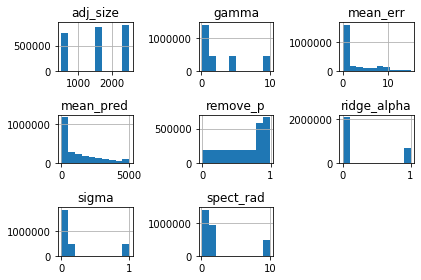

In [23]:
e = x[x.net == 'erdos'].copy()
show = ['mean_pred', 'mean_err', 'adj_size','gamma', 'sigma',
       'spect_rad', 'ridge_alpha', 'remove_p']
e[show].hist()
print('Erdos')
plt.tight_layout()

In [24]:
e.columns

Index(['mean_pred', 'mean_err', 'adj_size', 'topo_p', 'gamma', 'sigma',
       'spect_rad', 'ridge_alpha', 'remove_p', 'pred', 'err', 'net',
       'exp_num'],
      dtype='object')

In [25]:
hyp_p = ['adj_size', 'topo_p', 'gamma', 'sigma',
       'spect_rad', 'ridge_alpha']

# visualize
- plot subplots (row) for each hyper_parameter, 
- one row is including all adj_sizes
- the next row will be just that size, 

But ultimately I'll only want a row to one topology

In [34]:
#drop where the adj_size is null 
e[e.adj_size.isna()].index #to see where
x.drop(index=x[x.adj_size.isna()].index,inplace=True)

Int64Index([1814672, 1814673, 1814674, 1814677, 1814678, 1814679, 1814680,
            1814681, 1814682, 1814683,
            ...
            4923165, 4923166, 4923167, 4923168, 4923169, 4923170, 4923171,
            4923172, 4923173, 4923174],
           dtype='int64', length=269058)

# double check
make sure that the that the parameter actually selects the proper subset in the dataframe, when I first tested this it didn't seem to be working

`
ind = [] 
ind = e[e[v] == p].index
print(e.iloc[ind[0]])
print('\n\n')
`

In [149]:
resolution = int(1e3)
Tall = True
verbose = False
#HS is for hspace
# HS = 2
fig_height = 15
fig_width = 6.4
if Tall:
    fig, ax = plt.subplots(len(hyp_p),1,sharey=False,dpi=resolution,figsize=(fig_width,fig_height))
#     gs = gridspec.GridSpec(len(hyp_p), 1, figure=fig,hspace=HS)
else: 
    fig, ax = plt.subplots(1,len(hyp_p),sharey=False,dpi=resolution,figsize=(fig_width,fig_height))
#     gs = gridspec.GridSpec(1,len(hyp_p),figure=fig,hspace=HS)  

rp = x.remove_p.unique()
# each subplot is a different hyperparameter 
#for each subplot, plot all unique values of that parameter
topologies = ['erdos']
# dep for dependendent variable
dep = 'mean_pred'
# dep = 'mean_err'
for k, t in enumerate(topologies):
    e = x[x.net == t].copy()
    for i,v in enumerate(hyp_p):
        for j,p in enumerate(x[v].unique()):
            if verbose:
                print(i,v,j,p,'\n')
            S = e[e[v] == p].groupby(e.remove_p).aggregate(np.mean)[dep].copy()
            ax[i].plot(S.index,S.values,label=p) #if one topology
            ax[i].scatter(S.index,S.values)
        ax[i].legend(loc='lower left',prop={'size': 5},bbox_to_anchor=(1.1, 0.5))
        ax[i].set_title(v)
#     ax[i].set_xlabel('remove_p')
#     ax[i].set_ylabel('Mean pred')
fig.suptitle('Erdos Hyper-Parameter Comparison', fontsize=16,y=1.01)        
plt.tight_layout()

In [150]:
fig_num = 2
# fig.savefig(f'Erdos_HYP_comparison_{fig_num}.png')

In [153]:
x.net.unique()

array(['watts5', 'erdos', 'random_digraph'], dtype=object)

# RANDOM DIGRAPH

In [155]:
resolution = int(1e3)
Tall = True
verbose = False
#HS is for hspace
# HS = 2
fig_height = 15
fig_width = 6.4
if Tall:
    fig, ax = plt.subplots(len(hyp_p),1,sharey=False,dpi=resolution,figsize=(fig_width,fig_height))
#     gs = gridspec.GridSpec(len(hyp_p), 1, figure=fig,hspace=HS)
else: 
    fig, ax = plt.subplots(1,len(hyp_p),sharey=False,dpi=resolution,figsize=(fig_width,fig_height))
#     gs = gridspec.GridSpec(1,len(hyp_p),figure=fig,hspace=HS)  

rp = x.remove_p.unique()
# each subplot is a different hyperparameter 
#for each subplot, plot all unique values of that parameter
topologies = ['random_digraph']
# dep for dependendent variable
dep = 'mean_pred'
# dep = 'mean_err'
for k, t in enumerate(topologies):
    e = x[x.net == t].copy()
    for i,v in enumerate(hyp_p):
        for j,p in enumerate(x[v].unique()):
            if verbose:
                print(i,v,j,p,'\n')
            S = e[e[v] == p].groupby(e.remove_p).aggregate(np.mean)[dep].copy()
            ax[i].plot(S.index,S.values,label=p) #if one topology
            ax[i].scatter(S.index,S.values)
        ax[i].legend(loc='lower left',prop={'size': 5},bbox_to_anchor=(1.1, 0.5))
        ax[i].set_title(v)
#     ax[i].set_xlabel('remove_p')
#     ax[i].set_ylabel('Mean pred')
fig.suptitle(f'{t} Hyper-Parameter Comparison', fontsize=16,y=1.01)        
plt.tight_layout()

In [156]:
fig_num = 1
# fig.savefig(f'{t}_HYP_comparison_{fig_num}.png')

In [159]:
v = 'sigma'
p = 0.14
S = e[e[v] == p].groupby(e.remove_p).aggregate(np.mean)[dep].copy()
S

remove_p
0.00    2181.007470
0.10    2130.437401
0.20    2079.779430
0.30    2047.381517
0.40    2029.881792
0.50    2035.363111
0.60    2217.273196
0.70    2587.356383
0.80    2469.029851
0.84    2860.481481
0.88    1998.437500
0.90    2339.000000
0.92     787.000000
0.94    2964.600000
0.96    2903.500000
Name: mean_pred, dtype: float64

In [161]:
v = 'sigma'
p = 1
S = e[e[v] == p].groupby(e.remove_p).aggregate(np.mean)[dep].copy()
S

remove_p
0.00    1736.028475
0.10    1727.970917
0.20    1710.346027
0.30    1723.676356
0.40    1753.760915
0.50    1778.028777
0.60    1686.871383
0.70    1817.752874
0.80    1669.196970
0.84    2079.027778
0.88    1324.250000
0.90    2744.666667
0.92    2399.600000
0.94    1823.000000
0.96    3496.666667
Name: mean_pred, dtype: float64

# Watts5

In [162]:
resolution = int(1e3)
Tall = True
verbose = False
#HS is for hspace
# HS = 2
fig_height = 15
fig_width = 6.4
if Tall:
    fig, ax = plt.subplots(len(hyp_p),1,sharey=False,dpi=resolution,figsize=(fig_width,fig_height))
#     gs = gridspec.GridSpec(len(hyp_p), 1, figure=fig,hspace=HS)
else: 
    fig, ax = plt.subplots(1,len(hyp_p),sharey=False,dpi=resolution,figsize=(fig_width,fig_height))
#     gs = gridspec.GridSpec(1,len(hyp_p),figure=fig,hspace=HS)  

rp = x.remove_p.unique()
# each subplot is a different hyperparameter 
#for each subplot, plot all unique values of that parameter
topologies = ['watts5']
# dep for dependendent variable
dep = 'mean_pred'
# dep = 'mean_err'
for k, t in enumerate(topologies):
    e = x[x.net == t].copy()
    for i,v in enumerate(hyp_p):
        for j,p in enumerate(x[v].unique()):
            if verbose:
                print(i,v,j,p,'\n')
            S = e[e[v] == p].groupby(e.remove_p).aggregate(np.mean)[dep].copy()
            ax[i].plot(S.index,S.values,label=p) #if one topology
            ax[i].scatter(S.index,S.values)
        ax[i].legend(loc='lower left',prop={'size': 5},bbox_to_anchor=(1.1, 0.5))
        ax[i].set_title(v)
#     ax[i].set_xlabel('remove_p')
#     ax[i].set_ylabel('Mean pred')
fig.suptitle(f'{t} Hyper-Parameter Comparison', fontsize=16,y=1.01)        
plt.tight_layout()

In [163]:
fig_num = 1
# fig.savefig(f'{t}_HYP_comparison_{fig_num}.png')

# topo_p == 2 throws an error, sometimes

In [117]:
e.spect_rad.unique()

array([ 0.1,  0.9,  1. ,  1.1,  2. , 10. ])

In [121]:
parameter = 'spect_rad'
val = 1.1
print('this shows the problem was from indexing, not subsetting,\nwhich means I can go ahead with the hyper-parameter visualizing')
e[e[parameter] == val][hyp_p][parameter].unique()


this shows the problem was from indexing, not subsetting,
which means I can go ahead with the hyper-parameter visualizing


array([1.1])

In [106]:
parameter = 'topo_p'
val = 2
ind = e[e[parameter] == val].index
# ind[0]
a = set()
for i in range(len(ind[:700])):
    a.add(e.iloc[ind[0]][parameter])
a

IndexError: single positional indexer is out-of-bounds